### 필요한 패키지 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

### 데이터셋 생성

In [15]:
train = datasets.MNIST('../data', train=True, transform=transforms.Compose([
    transforms.ToTensor()
    ]), download=True)

test = datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor()
]))

x = train.data.float() / 255.
y = train.targets

x = x.view(x.size(0), -1)

print(f'X shape {x.size()} / y Shape {y.size()}')

input_size = x.size(1)
output_size = int(max(y)) + 1

print(f'Input Size of model {input_size}\nOuput Size of model {output_size}')

X shape torch.Size([60000, 784]) / y Shape torch.Size([60000])
Input Size of model 784
Ouput Size of model 10


In [18]:
train_cnt + valid_cnt

784.0

In [19]:
ratios = [0.8, 0.2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = test.data.size(0)

cnts = [train_cnt, valid_cnt]

print('Train %d / Valid %d / Test %d' %(cnts[0], cnts[1], test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim = 0, index = indices)
y = torch.index_select(y, dim = 0, index = indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

labels__ = ['Train', 'Valid', 'Test']
for l, x_i, y_i in zip(labels__, x, y):
    print(l, x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000
Train torch.Size([48000, 784]) torch.Size([48000])
Valid torch.Size([12000, 784]) torch.Size([12000])
Test torch.Size([10000, 784]) torch.Size([10000])


### 모델 생성


In [21]:
class Block(nn.Module):
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.3):

        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_nrom = use_batch_norm
        self.dropout_p = dropout_p
        
        super().__init__()
    
        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)

        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size)
        )

    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.block(x)
        # |y| = (batch_size, output_size)

        return y

In [45]:
class MyModel(nn.Module):
    def __init__(self, input_size, output_size, use_batch_norm=True, dropout_p=.3):

        super().__init__()

        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            Block(100, 50, use_batch_norm, dropout_p),
            nn.Linear(50, output_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.layers(x)
        # |y| = (batch_size, output_size)

        return y

In [46]:
model = MyModel(input_size, output_size, use_batch_norm=True)
print(model)

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [47]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [48]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [49]:
n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
lowest_epoch = np.inf

early_stop = 50
best_model = None

In [50]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train() ## 학습 모드..!!

    indices = torch.randperm(x[0].size(0)).to(device)

    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        
        loss = crit(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss
    
    train_loss = train_loss / len(x_)

    model.eval() ## 평가모드 (valid / test)
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)

            loss = crit(y_hat_i, y_i)

            valid_loss += float(loss)
            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_)

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    if (i + 1) % print_interval == 0:
        print('Epoch %d: Train Loss=%.4e / Valid Loss=%.4e / Lowest Loss=%.4e' %(
            i + 1,
            train_loss, 
            valid_loss,
            lowest_loss
        ))

    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict()) # 오류

    else:
        if early_stop > 0 and lowest_epoch + early_stop < i+1:
            print('Early Stopping!! last %d Epoch' % i)

            break

print('The best Validation Loss => %.4e Lowset epoch => %d' %(lowest_loss, lowest_epoch))
model.load_state_dict(best_model)

Epoch 10: Train Loss=2.0732e-02 / Valid Loss=8.2818e-02 / Lowest Loss=7.7201e-02
Epoch 20: Train Loss=1.3436e-02 / Valid Loss=8.2202e-02 / Lowest Loss=7.4232e-02
Epoch 30: Train Loss=6.5155e-03 / Valid Loss=6.9064e-02 / Lowest Loss=7.3753e-02
Epoch 40: Train Loss=8.1215e-03 / Valid Loss=7.4021e-02 / Lowest Loss=6.9064e-02
Epoch 50: Train Loss=4.0573e-03 / Valid Loss=7.8159e-02 / Lowest Loss=6.9064e-02
Epoch 60: Train Loss=3.2576e-03 / Valid Loss=8.3304e-02 / Lowest Loss=6.9064e-02
Epoch 70: Train Loss=2.1211e-03 / Valid Loss=7.7988e-02 / Lowest Loss=6.9064e-02
Epoch 80: Train Loss=4.7661e-03 / Valid Loss=8.0477e-02 / Lowest Loss=6.9064e-02
Early Stopping!! last 79 Epoch
The best Validation Loss => 6.9064e-02 Lowset epoch => 29


<All keys matched successfully>

In [70]:
t = [i.detach().numpy() for i in train_history]

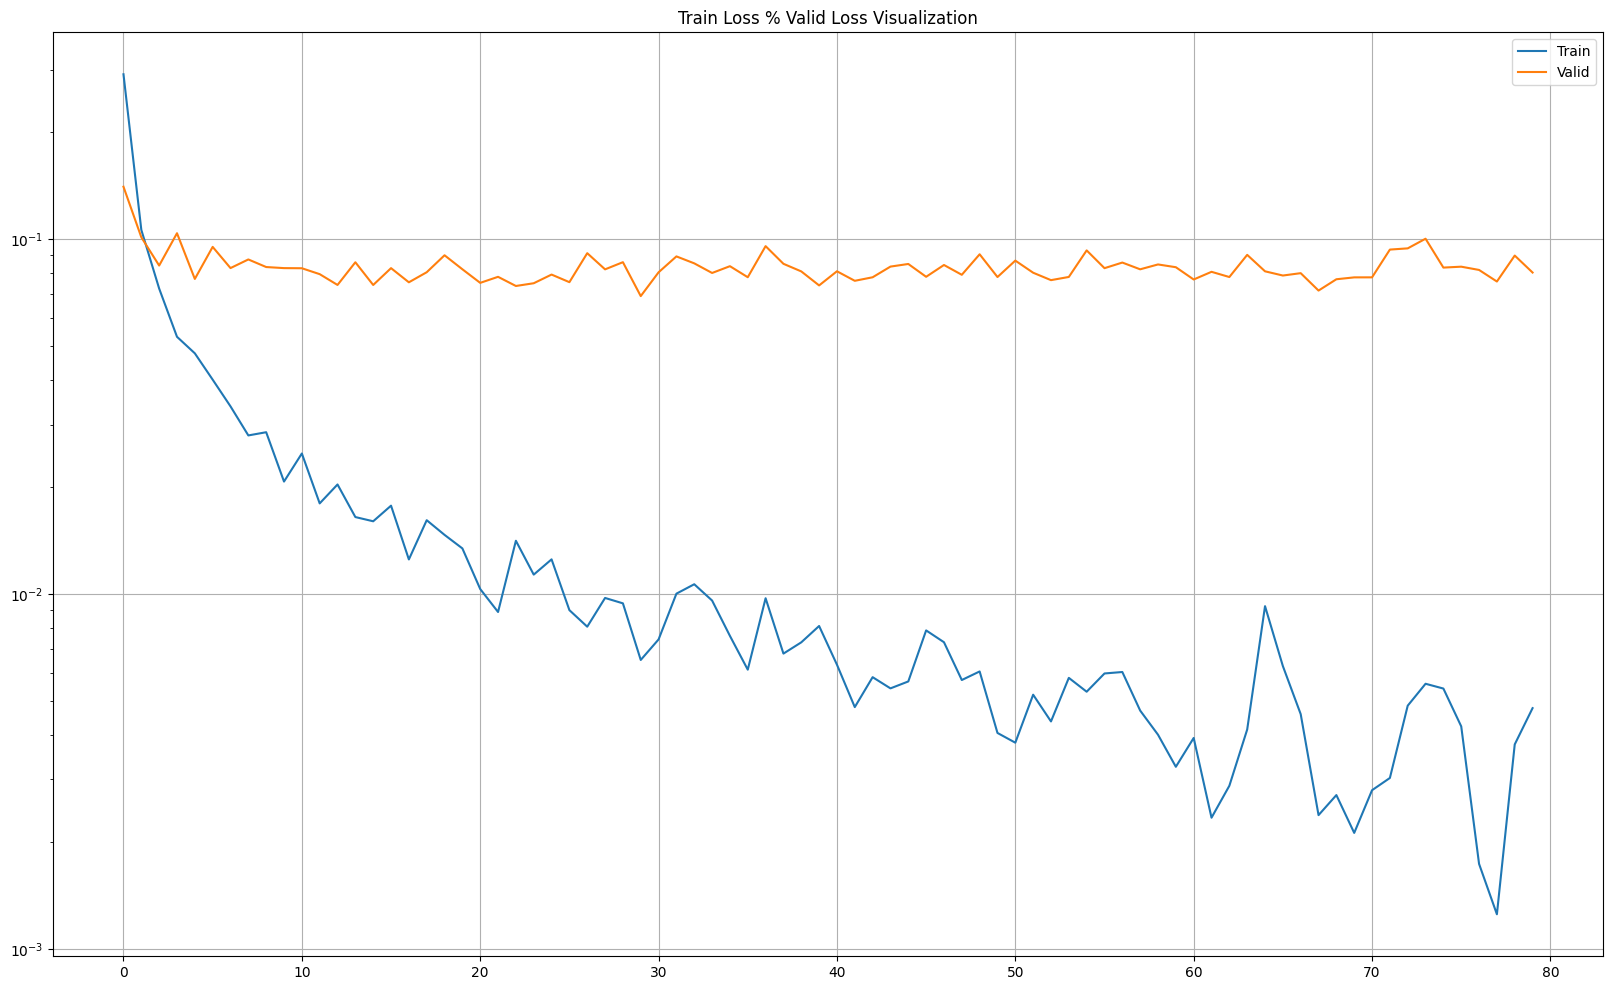

In [72]:
plot_from = 0

plt.figure(figsize=(20, 12))
plt.plot(range(plot_from, len(t)), t[plot_from:],
        range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.legend(['Train', 'Valid'])
plt.title('Train Loss % Valid Loss Visualization')
plt.yscale('log')
plt.grid(True)
plt.show()

In [73]:
test_loss = 0 
y_hat = []

with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)

        loss = crit(y_hat_i, y_i)

        test_loss += float(loss)
        y_hat.append(y_hat_i)

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print('Test Loss : %.4e'  % (test_loss))

Test Loss : 7.3138e-02


In [74]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Test Accuracy: %.4f' % (correct_cnt / total_cnt))


Test Accuracy: 0.9833


In [77]:
pd.DataFrame(np.stack([y[2], np.argmax(y_hat, axis=1)], axis=1), columns=['y', 'y_hat']).head()

,y,y_hat
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


In [79]:
from sklearn.metrics import classification_report

print(classification_report(y[2], np.argmax(y_hat, axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [84]:
# ERR (Error Reduction Rate) : 상대적인 모델의 개선폭 ㅇ측정
# ERR = (1-Prior Model Accuracy) - (1-Current Model Accuracy) / (1-Prior Model Accuracy)

err_rate = ((1-0.9775) - (1-(correct_cnt / total_cnt))) / (1-0.9775)
print(err_rate)

# 오류가 약 25% 줄어든 것을 확인할 수 있음!!

tensor(0.2578)
